In [1]:
import os
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas_datareader as web
from dateutil.relativedelta import relativedelta
import h5py
from dotenv import load_dotenv
import boto3
from botocore.exceptions import NoCredentialsError
from botocore.client import Config
from ticker_download_predict_upload import DownloadPredictUpload

In [2]:
dpu = DownloadPredictUpload()

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### Set the tickers in the portfolio

In [3]:
tickers = ["I:SPX", "QQQ", "VXUS", "GLD"]
D = len(tickers)

### Get the past year of ticker close prices

In [4]:
long_df_filename = os.path.join("input", f"Year of Tickers {dpu.get_today_date()}.csv")
if os.path.exists(long_df_filename):
    long_df = pd.read_csv(long_df_filename)
    long_df["datetime"] = pd.to_datetime(long_df["datetime"])
    long_df["datetime"] = long_df["datetime"].apply(
        lambda x: pd.Timestamp(x).replace(hour=23, minute=59, second=59)
    )
    long_df.set_index("datetime", inplace=True)
    long_df.sort_index(inplace=True)
else:
    date_from = dpu.past_business_day(pd.Timestamp(dpu.get_today_date()), 253)
    date_to = dpu.past_business_day(pd.Timestamp(dpu.get_today_date()), 1).replace(
        hour=23, minute=59, second=59
    )
    print(date_from, date_to)
    long_df = dpu.get_tickers(tickers, date_from=date_from, date_to=date_to)
    long_df.to_csv(long_df_filename, index=True)
long_df

,ticker,open,high,low,close,volume,vwap,transactions
datetime,,,,,,,,
2024-03-25 23:59:59,VXUS,59.92,60.145,59.890,59.99,2756590.0,60.0644,16491.0
2024-03-25 23:59:59,QQQ,443.55,446.260,442.540,444.76,27779904.0,445.0143,304143.0
2024-03-25 23:59:59,GLD,201.19,201.950,200.965,200.99,4034750.0,201.3506,43483.0
2024-03-25 23:59:59,I:SPX,5219.52,5229.090,5216.090,5218.19,NaN,NaN,NaN
2024-03-26 23:59:59,GLD,202.65,202.760,201.070,201.64,5752677.0,201.8118,65878.0
...,...,...,...,...,...,...,...,...
2025-03-27 23:59:59,I:SPX,5695.64,5732.280,5670.940,5693.31,NaN,NaN,NaN
2025-03-28 23:59:59,QQQ,479.81,480.520,468.050,468.94,46220997.0,472.5443,501464.0
2025-03-28 23:59:59,VXUS,62.96,62.960,62.385,62.51,4341931.0,62.5748,28383.0


### Pivot the close prices for better analysis

In [5]:
wide_df = dpu.pivot_ticker_close_wide(long_df)
wide_df

ticker,GLD,I:SPX,QQQ,VXUS
2024-03-25 17:00:00,200.99,5218.19,444.76,59.99
2024-03-26 17:00:00,201.64,5203.58,443.32,59.99
2024-03-27 17:00:00,203.10,5248.49,444.83,60.32
2024-03-28 17:00:00,205.72,5254.35,444.01,60.30
2024-04-01 17:00:00,207.82,5243.77,444.95,60.19
...,...,...,...,...
2025-03-24 17:00:00,277.25,5767.57,490.66,63.56
2025-03-25 17:00:00,278.47,5776.65,493.46,63.77
2025-03-26 17:00:00,278.24,5712.20,484.38,63.11
2025-03-27 17:00:00,281.97,5693.31,481.62,63.25


### Are there any missing values?

In [6]:
wide_df.isna().sum().sum()

np.int64(0)

### Calculate % change and covert to a percentage

In [7]:
returns_df = wide_df.pct_change()
returns_df = returns_df.iloc[1:] * 100
returns_df

ticker,GLD,I:SPX,QQQ,VXUS
2024-03-26 17:00:00,0.323399,-0.279982,-0.323770,0.000000
2024-03-27 17:00:00,0.724063,0.863060,0.340612,0.550092
2024-03-28 17:00:00,1.290005,0.111651,-0.184340,-0.033156
2024-04-01 17:00:00,1.020805,-0.201357,0.211707,-0.182421
2024-04-02 17:00:00,1.477240,-0.723907,-0.863018,-0.415351
...,...,...,...,...
2025-03-24 17:00:00,-0.445258,1.764604,2.042259,0.157580
2025-03-25 17:00:00,0.440036,0.157432,0.570660,0.330396
2025-03-26 17:00:00,-0.082594,-1.115699,-1.840068,-1.034969
2025-03-27 17:00:00,1.340569,-0.330696,-0.569801,0.221835


### Calculate mean returns

In [8]:
mean_returns = returns_df.mean()
mean_returns

ticker
GLD      0.141561
I:SPX    0.030425
QQQ      0.028525
VXUS     0.019864
dtype: float64

### Calculate covariance matrix

In [9]:
cov = returns_df.cov()
cov_np = cov.to_numpy()
cov

ticker,GLD,I:SPX,QQQ,VXUS
ticker,,,,
GLD,0.948674,0.173506,0.251971,0.342089
I:SPX,0.173506,0.772472,1.029063,0.504102
QQQ,0.251971,1.029063,1.518830,0.663323
VXUS,0.342089,0.504102,0.663323,0.721902


### Simulate 10,000 portfolios by generating random weights

In [10]:
n_portfolios = 10_000
d = len(mean_returns)
simulated_returns = np.zeros(n_portfolios)
simulated_risks = np.zeros(n_portfolios)
random_weights = []
rand_range = 1.0

for i in range(n_portfolios):
    w = np.random.random(d) * rand_range - rand_range / 2  # Allows short-selling
    w[-1] = 1 - w[:-1].sum()
    np.random.shuffle(w)
    random_weights.append(w)
    simulated_return = mean_returns.dot(w)
    simulated_risk = np.sqrt(w.dot(cov_np).dot(w))
    simulated_returns[i] = simulated_return
    simulated_risks[i] = simulated_risk

### Calculate minimum variance portfolio

In [11]:
weight_bounds = [(-0.5, None)] * D

In [12]:
def get_portfolio_variance(weights):
    return weights.dot(cov_np).dot(weights)

In [13]:
def portfolio_weights_constraint(weights):
    return weights.sum() - 1

In [14]:
min_var_result = minimize(
    fun=get_portfolio_variance,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
min_var_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.37542788793815945
       x: [ 3.182e-01  1.016e+00 -5.000e-01  1.657e-01]
     nit: 7
     jac: [ 8.178e-01  8.182e-01  9.526e-01  8.180e-01]
    nfev: 36
    njev: 7

In [15]:
min_var_risk = np.sqrt(min_var_result.fun)
min_var_weights = min_var_result.x
min_var_return = min_var_weights.dot(mean_returns)
min_var_risk, min_var_weights, min_var_return

(np.float64(0.6127217051306078),
 array([ 0.31822939,  1.01610085, -0.5       ,  0.16566976]),
 np.float64(0.06499262342777384))

### Calculate efficient frontier

In [16]:
num_portfolios = 100
target_returns = np.linspace(min_var_return, simulated_returns.max(), num_portfolios)
target_returns

array([0.06499262, 0.06739717, 0.06980171, 0.07220625, 0.07461079,
       0.07701533, 0.07941988, 0.08182442, 0.08422896, 0.0866335 ,
       0.08903804, 0.09144259, 0.09384713, 0.09625167, 0.09865621,
       0.10106076, 0.1034653 , 0.10586984, 0.10827438, 0.11067892,
       0.11308347, 0.11548801, 0.11789255, 0.12029709, 0.12270163,
       0.12510618, 0.12751072, 0.12991526, 0.1323198 , 0.13472435,
       0.13712889, 0.13953343, 0.14193797, 0.14434251, 0.14674706,
       0.1491516 , 0.15155614, 0.15396068, 0.15636522, 0.15876977,
       0.16117431, 0.16357885, 0.16598339, 0.16838794, 0.17079248,
       0.17319702, 0.17560156, 0.1780061 , 0.18041065, 0.18281519,
       0.18521973, 0.18762427, 0.19002881, 0.19243336, 0.1948379 ,
       0.19724244, 0.19964698, 0.20205153, 0.20445607, 0.20686061,
       0.20926515, 0.21166969, 0.21407424, 0.21647878, 0.21888332,
       0.22128786, 0.2236924 , 0.22609695, 0.22850149, 0.23090603,
       0.23331057, 0.23571512, 0.23811966, 0.2405242 , 0.24292

In [17]:
def target_returns_constraint(weights, target_return):
    return weights.dot(mean_returns) - target_return

In [18]:
constraints = [
    {"type": "eq", "fun": target_returns_constraint, "args": [target_returns[0]]},
    {"type": "eq", "fun": portfolio_weights_constraint},
]

In [19]:
optimized_risks = []
for target_return in target_returns:
    constraints[0]["args"] = [target_return]
    result = minimize(
        fun=get_portfolio_variance,
        x0=np.ones(D) / D,
        method="SLSQP",
        bounds=weight_bounds,
        constraints=constraints,
    )
    if result.status == 0:
        optimized_risks.append(np.sqrt(result.fun))
    else:
        print("Optimization error!", result)

### Calculate Sharpe Ratio

In [20]:
today_date = dpu.get_today_date()
risk_free_rate_filename = os.path.join("input", f"Risk Free Rate {today_date}.json")
if os.path.exists(risk_free_rate_filename):
    print("Reading risk-free rate cache...")
    with open(risk_free_rate_filename, "r", encoding="utf-8") as f:
        risk_free_rate_data = json.load(f)
        print(risk_free_rate_data)
        daily_risk_free_rate = risk_free_rate_data["daily_risk_free_rate"]
else:
    end_date = datetime.datetime.now()
    start_date = end_date - relativedelta(years=1)
    print(start_date, end_date)
    tb3m_df = web.DataReader("DTB3", "fred", start_date, end_date).sort_values(
        "DATE", ascending=False
    )
    risk_free_rate = float(tb3m_df.iloc[0]["DTB3"])
    daily_risk_free_rate = risk_free_rate / 252
    risk_free_rate_date = str(tb3m_df.index[0])
    print(daily_risk_free_rate)
    risk_free_rate_data = {
        "risk_free_rate": risk_free_rate,
        "daily_risk_free_rate": daily_risk_free_rate,
        "risk_free_rate_date": risk_free_rate_date,
    }
    with open(risk_free_rate_filename, "w", encoding="utf-8") as f:
        json.dump(risk_free_rate_data, f, indent=4)

Reading risk-free rate cache...
{'risk_free_rate': 4.2, 'daily_risk_free_rate': 0.016666666666666666, 'risk_free_rate_date': '2025-03-27 00:00:00'}


In [21]:
def negative_sharpe_ratio(weights):
    mean = weights.dot(mean_returns)
    risk = np.sqrt(weights.dot(cov_np).dot(weights))
    return -(mean - daily_risk_free_rate) / risk

In [22]:
sharpe_ratio_result = minimize(
    fun=negative_sharpe_ratio,
    x0=np.ones(D) / D,
    method="SLSQP",
    bounds=weight_bounds,
    constraints={"type": "eq", "fun": portfolio_weights_constraint},
)
sharpe_ratio_result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.14404480628045932
       x: [ 1.074e+00  9.265e-01 -5.000e-01 -5.000e-01]
     nit: 17
     jac: [-1.051e-02 -1.061e-02 -9.040e-03  1.279e-03]
    nfev: 85
    njev: 17

In [23]:
best_sharpe_ratio = -sharpe_ratio_result.fun
best_weights = sharpe_ratio_result.x
opt_risk = np.sqrt(best_weights.dot(cov_np).dot(best_weights))
opt_return = best_weights.dot(mean_returns)
best_sharpe_ratio, best_weights

(np.float64(0.14404480628045932),
 array([ 1.07354336,  0.92645664, -0.5       , -0.5       ]))

### Calculate tangency line

In [24]:
tangency_max_risk = max(optimized_risks)
tangency_xs = np.linspace(0, tangency_max_risk, 100)
tangency_ys = daily_risk_free_rate + best_sharpe_ratio * tangency_xs

### FINALLY! Put it all on a plot

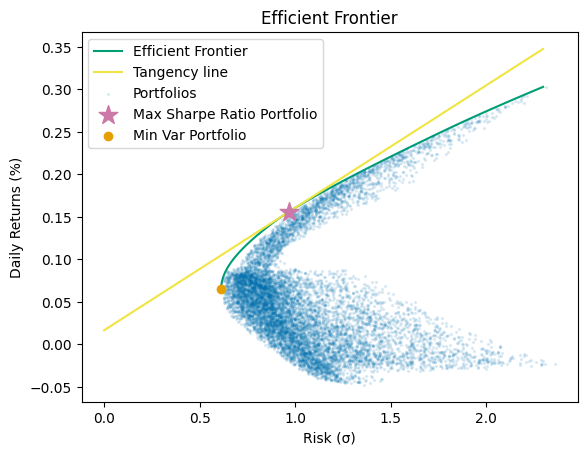

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(
    optimized_risks, target_returns, c="#009E73", zorder=1, label="Efficient Frontier"
)
ax.plot(tangency_xs, tangency_ys, c="#F0E442", zorder=1, label="Tangency line")
ax.scatter(
    simulated_risks,
    simulated_returns,
    alpha=0.1,
    s=2,
    c="#0072B2",
    zorder=10,
    label="Portfolios",
)
ax.scatter(
    [opt_risk],
    [opt_return],
    c="#CC79A7",
    marker="*",
    s=200,
    zorder=10,
    label="Max Sharpe Ratio Portfolio",
)
ax.scatter(
    [min_var_risk], [min_var_return], c="#E69F00", zorder=10, label="Min Var Portfolio"
)
ax.set_xlabel("Risk (σ)")
ax.set_ylabel("Daily Returns (%)")
ax.set_title("Efficient Frontier")
ax.legend()

### Annualize optimum return.

In [26]:
((1 + opt_return / 100) ** 252 - 1) * 100

np.float64(48.10140988260174)

### Write an HDF5 file with everything needed to regenerate plot

In [27]:
portfolio_optimization_plot_data_filename = os.path.join(
    "output", "portfolio_optimization_plot_data.h5"
)
with h5py.File(portfolio_optimization_plot_data_filename, "w") as hf:
    efficient_frontier_group = hf.create_group("efficient_frontier")
    tangency_line_group = hf.create_group("tangency_line")
    simulated_portfolios_group = hf.create_group("simulated_portfolios")
    max_sharpe_ratio_group = hf.create_group("max_sharpe_ratio")
    min_var_portfolio_group = hf.create_group("min_var_portfolio")
    efficient_frontier_group.create_dataset("xs", data=optimized_risks)
    efficient_frontier_group.create_dataset("ys", data=target_returns)
    tangency_line_group.create_dataset("xs", data=tangency_xs)
    tangency_line_group.create_dataset("ys", data=tangency_ys)
    simulated_portfolios_group.create_dataset("xs", data=simulated_risks)
    simulated_portfolios_group.create_dataset("ys", data=simulated_returns)
    max_sharpe_ratio_group.create_dataset("xs", data=[opt_risk])
    max_sharpe_ratio_group.create_dataset("ys", data=[opt_return])
    min_var_portfolio_group.create_dataset("xs", data=[min_var_risk])
    min_var_portfolio_group.create_dataset("ys", data=[min_var_return])
print(f"Saved {portfolio_optimization_plot_data_filename}")

Saved output/portfolio_optimization_plot_data.h5


In [28]:
load_dotenv()
endpoint_url = os.getenv("FSF_FRONT_END_BUCKET_ENDPOINT")
aws_access_key_id = os.getenv("FSF_FRONT_END_BUCKET_KEY_ID")
aws_secret_access_key = os.getenv("FSF_FRONT_END_BUCKET_RWDELETE")
region_name = os.getenv("FSF_FRONT_END_BUCKET_REGION")
space_name = "portfolio-optimization"

session = boto3.session.Session()
client = session.client('s3',
                        region_name=region_name,
                        endpoint_url=endpoint_url,
                        aws_access_key_id=aws_access_key_id,
                        aws_secret_access_key=aws_secret_access_key,
                        config=Config(signature_version='s3v4'))

try:
    client.upload_file(portfolio_optimization_plot_data_filename, space_name, "portfolio_optimization_plot_data.h5")
    print(f"Upload successful!")
except FileNotFoundError:
    print("The file was not found")
except NoCredentialsError:
    print("Credentials not available")

Upload successful!
